# Helper

In [10]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

def rmssd_from_rr(rr_ms: pd.Series) -> float:
    rr = rr_ms.dropna().values.astype(float)
    if len(rr) < 2:
        return np.nan
    diff = np.diff(rr)
    return np.sqrt(np.mean(diff**2))

def load_rmssd_df(json_path: str = "experiment_data_with_hr.json"):
    """
    Loads experiment JSON (relative to this file), computes RMSSD per video stimulus,
    and returns rmssd_df (long) and mean_table (participant-level pivot).
    """
    jf = Path(json_path)

    with jf.open("r", encoding="utf-8") as f:
        participants = json.load(f)

    rows = []
    for p in participants:
        pid = p["participant_id"]
        for stim in p.get("stimuli", []):
            vid_id = stim.get("video_id")
            stim_id = stim.get("id")
            hr_rows = stim.get("heart_rate", []) or []
            if not hr_rows:
                rmssd_ms = np.nan
            else:
                df_hr = pd.DataFrame(hr_rows)
                if "ArtifactCorrectedRR" not in df_hr.columns or "ts" not in df_hr.columns:
                    rmssd_ms = np.nan
                else:
                    df_hr["ts"] = pd.to_datetime(df_hr["ts"], errors="coerce")
                    df_hr = df_hr.dropna(subset=["ts", "ArtifactCorrectedRR"]).sort_values("ts")
                    rmssd_ms = rmssd_from_rr(df_hr["ArtifactCorrectedRR"])
            belief = (stim.get("video_response", {}) or {}).get("belief")
            rows.append({
                "participant_id": pid,
                "stim_id": stim_id,
                "video_id": vid_id,
                "belief": belief,
                "RMSSD_ms": rmssd_ms,
                "RMSSD_seconds": rmssd_ms / 1000.0 if pd.notna(rmssd_ms) else np.nan,
            })

    rmssd_df = pd.DataFrame(rows)
    # standardize belief strings
    if "belief" in rmssd_df.columns:
        rmssd_df["belief"] = rmssd_df["belief"].astype(str).str.strip()
    mean_table = rmssd_df.pivot_table(index="participant_id", columns="belief", values="RMSSD_ms", aggfunc="mean")
    return rmssd_df, mean_table


# Wilcoxon signed rank test
After having verified in [the preliminary analysis](./data_analysis_preliminary.ipynb) that the data is **not** normally distributed, we applied the [Wilcoxon signed rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) to obtain the statistical significance of the within-subjects difference of RMSSD

In [11]:
from scipy.stats import wilcoxon

# load precomputed tables
rmssd_df, mean_table = load_rmssd_df()  # adjust path arg if JSON is elsewhere

# select paired participant-level means (drop participants missing either label)
paired = mean_table[["AI Generated", "Human Generated"]].dropna()
ai_vals = paired["AI Generated"].values
human_vals = paired["Human Generated"].values

stat, p = wilcoxon(ai_vals, human_vals, alternative="two-sided", zero_method="wilcox")
n = len(ai_vals)

# approximate effect size r
expected_W = n * (n + 1) / 4.0
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24.0)
z = (stat - expected_W) / std_W if std_W > 0 else np.nan
r = z / np.sqrt(n) if n > 0 else np.nan

print(f"n = {n}")
print(f"Wilcoxon W = {stat:.3f}, p = {p:.4f}")
print(f"approx. z = {z:.3f}, effect size r = {r:.3f}")
print(f"median AI = {np.median(ai_vals):.3f}, median Human = {np.median(human_vals):.3f}, median(AI-Human) = {np.median(ai_vals-human_vals):.3f}")

n = 22
Wilcoxon W = 102.000, p = 0.4434
approx. z = -0.795, effect size r = -0.170
median AI = 32.323, median Human = 32.109, median(AI-Human) = -0.463


## Confidence intervals and plots

Hodges-Lehmann (median difference) = -0.463 ms
Bootstrap 95% CI (percentile) for median difference = [-3.950, 1.793] ms


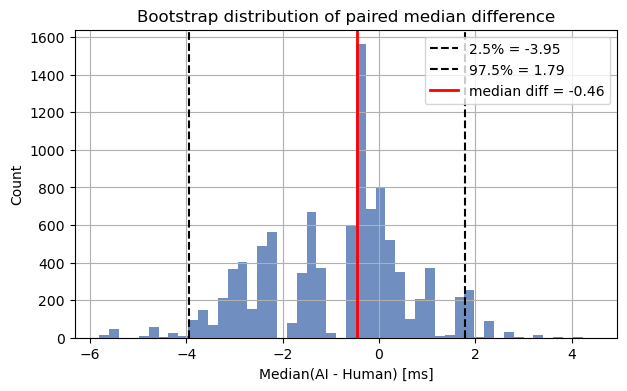

'AI-generated' median = 32.323 ms, bootstrap 95% CI = [15.473, 60.439]
'Human-generated' median = 32.109 ms, bootstrap 95% CI = [18.141, 52.567]


In [12]:
# -----------------------------
# Bootstrap 95% CI for median difference (paired)
# -----------------------------

diffs = ai_vals - human_vals
hl = np.median(diffs)  # Hodges-Lehmann (median of paired differences)

def bootstrap_paired_median_diff(a, b, n_boot=10000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(a)
    # resample participant indices with replacement
    idxs = rng.integers(0, n, size=(n_boot, n))
    boot_meds = np.array([np.median(a[idx] - b[idx]) for idx in idxs])
    return boot_meds

boot_meds = bootstrap_paired_median_diff(ai_vals, human_vals, n_boot=10000, seed=42)
ci_lower, ci_upper = np.percentile(boot_meds, [2.5, 97.5])

print(f"Hodges-Lehmann (median difference) = {hl:.3f} ms")
print(f"Bootstrap 95% CI (percentile) for median difference = [{ci_lower:.3f}, {ci_upper:.3f}] ms")

# Plot bootstrap distribution
plt.figure(figsize=(7,4))
plt.hist(boot_meds, bins=50, color="#4c72b0", alpha=0.8)
plt.axvline(ci_lower, color="k", linestyle="--", label=f"2.5% = {ci_lower:.2f}")
plt.axvline(ci_upper, color="k", linestyle="--", label=f"97.5% = {ci_upper:.2f}")
plt.axvline(hl, color="red", linewidth=2, label=f"median diff = {hl:.2f}")
plt.xlabel("Median(AI - Human) [ms]")
plt.ylabel("Count")
plt.title("Bootstrap distribution of paired median difference")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Optional: bootstrap CIs for marginal medians (AI, Human)
# -----------------------------
def bootstrap_paired_marginal_medians(a, b, n_boot=10000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(a)
    idxs = rng.integers(0, n, size=(n_boot, n))
    boot_med_a = np.array([np.median(a[idx]) for idx in idxs])
    boot_med_b = np.array([np.median(b[idx]) for idx in idxs])
    return boot_med_a, boot_med_b

boot_med_a, boot_med_b = bootstrap_paired_marginal_medians(ai_vals, human_vals, n_boot=10000, seed=42)
ai_ci = np.percentile(boot_med_a, [2.5, 97.5])
human_ci = np.percentile(boot_med_b, [2.5, 97.5])

print(f"'AI-generated' median = {np.median(ai_vals):.3f} ms, bootstrap 95% CI = [{ai_ci[0]:.3f}, {ai_ci[1]:.3f}]")
print(f"'Human-generated' median = {np.median(human_vals):.3f} ms, bootstrap 95% CI = [{human_ci[0]:.3f}, {human_ci[1]:.3f}]")

# GLMM
In order to include the prior opinon about AI as a possible collateral effect of the previous results, we applied the [GLMM test](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model)

In [13]:
# load precomputed tables
rmssd_labeled, mean_table = load_rmssd_df()  # adjust path arg if JSON is elsewhere

## Extract attitude from PsychoPy trial CSVs

In [14]:
import pandas as pd
from glob import glob
import os

attitudes = {}

for path in glob("../trials_psychopy/*_manipulation-of-belief_*.csv"):
    df = pd.read_csv(path)

    # Get participant ID from filename
    # Example filename: "1_manipulation-of-belief_2025-11-12_14h45.39.812.csv"
    filename = os.path.basename(path)
    pid = int(filename.split("_")[0])

    # Extract attitude rating (first non-NaN opinion_slider.response)
    attitude = df["opinion_slider.response"].dropna().iloc[0]

    attitudes[pid] = attitude

print("Attitudes dict:", attitudes)


Attitudes dict: {5: np.float64(1.0), 11: np.float64(3.0), 18: np.float64(3.0), 23: np.float64(4.0), 6: np.float64(3.0), 20: np.float64(4.0), 8: np.float64(2.0), 2: np.float64(4.0), 4: np.float64(2.0), 17: np.float64(4.0), 16: np.float64(4.0), 15: np.float64(4.0), 7: np.float64(1.0), 12: np.float64(5.0), 19: np.float64(2.0), 22: np.float64(2.0), 1: np.float64(2.0), 21: np.float64(3.0), 13: np.float64(4.0), 3: np.float64(3.0), 10: np.float64(4.0), 14: np.float64(3.0)}


In [15]:
rmssd_labeled["attitude_AI"] = rmssd_labeled["participant_id"].map(attitudes)


## Prepare data for GLMM

In [16]:
glmm_df = rmssd_labeled.copy()

# Standardize labels
glmm_df["belief_label"] = glmm_df["belief"].str.strip()

# Convert belief to binary predictor (optional, easier for GLMM)
glmm_df["assumed_AI"] = (glmm_df["belief_label"] == "AI Generated").astype(int)

# Drop rows with missing RMSSD
glmm_df = glmm_df.dropna(subset=["RMSSD_ms", "attitude_AI"])

glmm_df.head()


,participant_id,stim_id,video_id,belief,RMSSD_ms,RMSSD_seconds,attitude_AI,belief_label,assumed_AI
0,1,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,6.574545,0.006575,2.0,Human Generated,0
1,1,2,5768645-uhd_3840_2160_25fps.mp4,Human Generated,3.438652,0.003439,2.0,Human Generated,0
2,1,3,18840567-hd_1920_1080_30fps.mp4,AI Generated,9.947126,0.009947,2.0,AI Generated,1
3,1,4,11946387_3840_2160_30fps.mp4,AI Generated,11.292927,0.011293,2.0,AI Generated,1
4,2,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,9.658932,0.009659,4.0,Human Generated,0


## Fit a GLMM

In [17]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "RMSSD_ms ~ assumed_AI + attitude_AI + assumed_AI:attitude_AI",
    data=glmm_df,
    groups=glmm_df["participant_id"],
)
result = model.fit()
print(result.summary())



               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     RMSSD_ms 
No. Observations:     88          Method:                 REML     
No. Groups:           22          Scale:                  119.6614 
Min. group size:      4           Log-Likelihood:         -359.1060
Max. group size:      4           Converged:              Yes      
Mean group size:      4.0                                          
-------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------
Intercept               53.883   17.231  3.127 0.002  20.111 87.655
assumed_AI              -6.339    7.065 -0.897 0.370 -20.186  7.508
attitude_AI             -5.365    5.341 -1.005 0.315 -15.833  5.103
assumed_AI:attitude_AI   1.878    2.190  0.858 0.391  -2.413  6.170
Group Var              651.965   22.581                        

#### Labeling a video as AI vs Human did not significantly affect RMSSD, nor did attitudes toward AI, nor their interaction.

## Test

In [18]:
import pandas as pd
import numpy as np

# Drop rows with missing data
glmm_data = glmm_df.dropna(subset=["RMSSD_ms", "assumed_AI", "attitude_AI", "participant_id"]).copy()

# (Optional) center attitude for nicer interpretation
glmm_data["attitude_c"] = glmm_data["attitude_AI"] - glmm_data["attitude_AI"].mean()


In [ ]:
import statsmodels.api as sm

data.exog = sm.add_constant(data.exog)

# Instantiate a gamma family model with the default link function.
gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

NameError: name 'data' is not defined

## Mean RMSSD by Assumed Label (AI-labeled vs Human-labeled)

C:\Users\jasmi\AppData\Local\Temp\ipykernel_20168\3124528653.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
C:\Users\jasmi\AppData\Local\Temp\ipykernel_20168\3124528653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


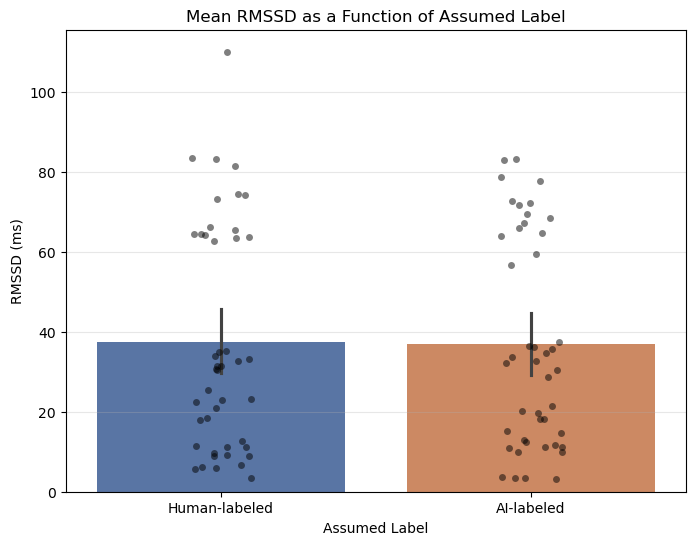

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.barplot(
    data=glmm_df,
    x="assumed_AI",
    y="RMSSD_ms",
    estimator="mean",
    ci=95,
    palette=["#4C72B0", "#DD8452"],
)

sns.stripplot(
    data=glmm_df,
    x="assumed_AI",
    y="RMSSD_ms",
    color="black",
    alpha=0.5,
    jitter=0.1
)

plt.xticks([0, 1], ["Human-labeled", "AI-labeled"])
plt.xlabel("Assumed Label")
plt.ylabel("RMSSD (ms)")
plt.title("Mean RMSSD as a Function of Assumed Label")
plt.grid(axis="y", alpha=0.3)

plt.show()


## Code for a modeled marginal interaction plot

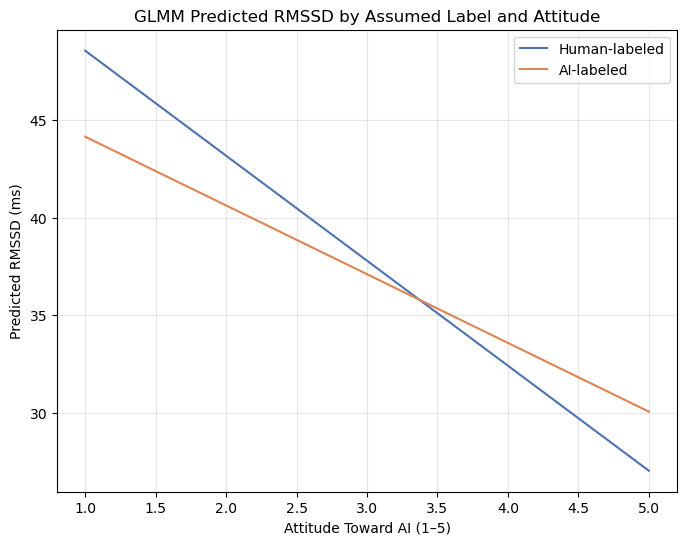

In [ ]:
import numpy as np

# Create prediction grid
att_vals = np.linspace(glmm_df["attitude_AI"].min(),
                       glmm_df["attitude_AI"].max(), 100)
pred_df = pd.DataFrame({
    "attitude_AI": att_vals,
    "assumed_AI": 0
})
pred_df2 = pred_df.copy()
pred_df2["assumed_AI"] = 1

# Predict from model
pred_df["RMSSD_pred"] = result.predict(pred_df)
pred_df2["RMSSD_pred"] = result.predict(pred_df2)

plt.figure(figsize=(8,6))
plt.plot(pred_df["attitude_AI"], pred_df["RMSSD_pred"], label="Human-labeled", color="#4C72B0")
plt.plot(pred_df2["attitude_AI"], pred_df2["RMSSD_pred"], label="AI-labeled", color="#DD8452")
plt.xlabel("Attitude Toward AI (1–5)")
plt.ylabel("Predicted RMSSD (ms)")
plt.title("GLMM Predicted RMSSD by Assumed Label and Attitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 95% Confidence Intervals for the GLMM estimates

In [ ]:
ci = result.conf_int()
ci.columns = ["CI_lower", "CI_upper"]
ci


,CI_lower,CI_upper
Intercept,20.113899,87.660533
assumed_AI,-20.089833,7.594707
attitude_AI,-15.833199,5.102975
assumed_AI:attitude_AI,-2.437248,6.143614
Group Var,1.403786,9.502130
